In [1]:
%load_ext autoreload
%autoreload 2

## Imports

### Libraries

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary
from torch.optim import lr_scheduler
from torch import optim
import copy
from datetime import time
import wandb
import os

### Custom

In [3]:
from cv_geoguessr.grid.grid_partitioning import Partitioning
from cv_geoguessr.utils.plot_images import plot_images
from cv_geoguessr.utils.evaluation import create_confusion_matrix
from cv_geoguessr.data.data_loader import get_data_loader
from cv_geoguessr.data.data_loader import preview_images
from cv_geoguessr.network.training import train_model
from cv_geoguessr.network.model import load_model
from cv_geoguessr.network.model import lock_layers


## Colab specific

Run only when using Colab.

In [4]:
COLAB = False

if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')


## Model constants

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

SAMPLES_TO_SHOW = 5

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=device)
IMAGENET_STD = torch.tensor([0.229, 0.224, 0.225], device=device)

CITY_BOUNDS_FILE = '../data/metadata/city bounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'
GCLOUD_LONDON_PHOTO_DIR = lambda train: f'../data/images/{"train" if train else "test"}/'

LONDON_PHOTO_DIR = GCLOUD_LONDON_PHOTO_DIR

SESSION = "super-sweep-1"
BASE_FOLDER = "./checkpoints"
CHECKPOINT_FOLDER = f'{BASE_FOLDER}/{SESSION}/'

Device: cuda:0


In [14]:
config = {
    "train_batch_size": 32,
    "test_batch_size": 100,
    "cell_width": 0.01,
    "voronoi": True,
    "lr": 0.001,
    "momentum": 0.9,
    "gamma": 0.1,
    "lr_decay_step": 7,
    "epochs": 25,
    "lock_factor": 1 # How much of the layers are locked 1 for every thing 0 for training the whole model
}

### Set up grid partitioning

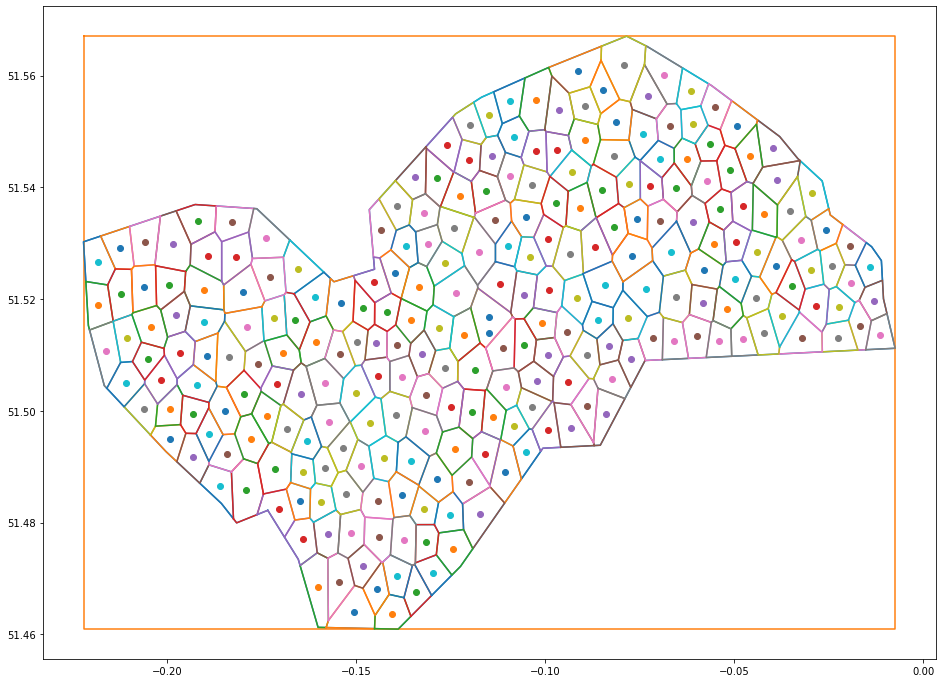

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,12))
grid_partitioning = Partitioning(CITY_BOUNDS_FILE,
                                 cell_width=config["cell_width"],
                                 voronoi=config["voronoi"])
config["number_of_grid_elements"] = len(grid_partitioning)
grid_partitioning.plot()

### Create the data loaders

In [7]:
data_loaders, data_set_sizes = get_data_loader(LONDON_PHOTO_DIR, grid_partitioning,
                                               config["train_batch_size"],
                                               config["test_batch_size"],
                                               IMAGENET_MEAN,
                                               IMAGENET_STD)

In [19]:
## Train on the grid output

resnet50 = models.resnet50(pretrained=True, progress=True)
resnet50.to(device)
resnet50 = lock_layers(resnet50, (3, 224, 224), config["lock_factor"])
resnet50.fc = nn.Linear(resnet50.fc.in_features, config["number_of_grid_elements"])
resnet50.to(device)
print(config["lock_factor"])
summary(resnet50, (3, 224, 224))

174/174 layers locked
317/317 params locked
1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          

In [23]:
def setup_and_train():
    with wandb.init(project="CV-GeoGuessr", entity="cv-geoguessr", config={**config}) as run:
        wandbconfig = wandb.config

        SESSION = wandb.run.name
        BASE_FOLDER = "./checkpoints"
        CHECKPOINT_FOLDER = f'{BASE_FOLDER}/{SESSION}/'

        # Create the model and lock the layers
        resnet50 = models.resnet50(pretrained=True, progress=True)
        resnet50.to(device)
        resnet50 = lock_layers(resnet50, (3, 224, 224), wandbconfig["lock_factor"])
        resnet50.fc = nn.Linear(resnet50.fc.in_features, wandbconfig["number_of_grid_elements"])
        for param in resnet50.fc.parameters():
            param.requires_grad = True

        resnet50.to(device)

        # create the checkpoint folder and save the untrained model
        if not os.path.isdir(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        torch.save(resnet50.state_dict(), CHECKPOINT_FOLDER + "0.ckpt")

        # Define the criterion, optimizer and exp_lr_scheduler
        criterion = nn.CrossEntropyLoss()
        optimizer_ft = optim.SGD(resnet50.parameters(), lr=wandbconfig["lr"], momentum=wandbconfig["momentum"])
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=wandbconfig["lr_decay_step"], gamma=wandbconfig["gamma"])

        # Train the model
        resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler, data_loaders,
                       data_set_sizes, grid_partitioning, CHECKPOINT_FOLDER, device, num_epochs=config["epochs"])

In [24]:
config["lock_factor"] = 1

setup_and_train()

174/174 layers locked
317/317 params locked
Epoch 0/24
----------
train loss: 5.5182 | accuracy: 0.0078                 
val loss: 5.4720 | accuracy: 0.0140                 
0.007770472205618649	0.014
Epoch 1/24
----------
train loss: 5.4243 | accuracy: 0.0153                 
val loss: 5.3962 | accuracy: 0.0200                 
0.015341701534170154	0.02
Epoch 2/24
----------
train loss: 5.3424 | accuracy: 0.0250                 
val loss: 5.3427 | accuracy: 0.0205                 
0.02500498107192668	0.0205
Epoch 3/24
----------
train loss: 5.2686 | accuracy: 0.0309                 
val loss: 5.3126 | accuracy: 0.0215                 
0.03088264594540745	0.021500000000000002
Epoch 4/24
----------
train loss: 5.2027 | accuracy: 0.0371                 
val loss: 5.2614 | accuracy: 0.0240                 
0.03705917513448894	0.024
Epoch 5/24
----------
train loss: 5.1354 | accuracy: 0.0466                 
val loss: 5.2243 | accuracy: 0.0350                 
0.04662283323371189	0.035
Epo

Accuracy/train,▁▂▃▃▄▅▅▇▇▇▇██▇███████████
Accuracy/val,▁▃▃▃▄▇▆▇▇▇▇▇▇█▇████████▇▇
Distance/train,█▅▂▃▂▁▆▄▇▃▄▄▅▅▅▅▅▄▄▅▅▄▄▅▅
Distance/val,██▂▃▁▂▆▄▇▃▄▄▅▅▅▅▅▅▅▄▄▅▄▅▅
Loss/train,█▇▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▆▅▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Accuracy/train,0.0779
Accuracy/val,0.0385
Distance/train,0.06611
Distance/val,0.0659


In [ ]:
config["lock_factor"] = 0.5

setup_and_train()


88/174 layers locked
153/317 params locked
Epoch 0/24
----------
train loss: 5.4996 | accuracy: 0.0104                 
val loss: 5.4009 | accuracy: 0.0135                 
0.010360629607491532	0.0135
Epoch 1/24
----------
train loss: 5.2513 | accuracy: 0.0261                 
val loss: 5.1746 | accuracy: 0.0270                 
0.026100816895795974	0.027
Epoch 2/24
----------
train loss: 4.9663 | accuracy: 0.0482                 
val loss: 4.9606 | accuracy: 0.0395                 
0.048216776250249054	0.0395
Epoch 3/24
----------
train loss: 4.7192 | accuracy: 0.0710                 
val loss: 4.7983 | accuracy: 0.0505                 
0.07103008567443714	0.0505
Epoch 4/24
----------
train loss: 4.4914 | accuracy: 0.0938                 
val loss: 4.6503 | accuracy: 0.0615                 
0.09384339509862523	0.0615
Epoch 5/24
----------
train loss: 4.2654 | accuracy: 0.1284                 
val loss: 4.5488 | accuracy: 0.0745                 
0.12841203426977485	0.0745
Epoch 6/24
--

In [ ]:
config["lock_factor"] = 0

setup_and_train()

In [ ]:
sweep_config = {
  "name" : "unlock sweep 3",
  "method" : "grid",
  # "metric" : {
  #     "name" : "Accuracy/val",
  #     "goal" : "maximize"
  # },
  "parameters" : {
    "lock_factor": {
        "values": [0.9, 0.7, 0.6, 0.5]
    },
    # "lr": {
    #     "min" : 0.0005,
    #     "max" : 0.005,
    # },
    # "momentum": {
    #     "min" : 0.7,
    #     "max" : 1.0,
    # },
    # "gamma": {
    #     "min" : 0.0,
    #     "max" : 0.5,
    # },
    # "lr_decay_step": {
    #     "min" : 2,
    #     "max" : 20,
    # },
  }
}


sweep_id = wandb.sweep(sweep_config, project="CV-GeoGuessr", entity="cv-geoguessr")

# count = 10 # number of runs to execute
wandb.agent(sweep_id, function=setup_and_train, project="CV-GeoGuessr", entity="cv-geoguessr")

Create sweep with ID: 9c1z2m2m
Sweep URL: https://wandb.ai/cv-geoguessr/CV-GeoGuessr/sweeps/9c1z2m2m


wandb: Agent Starting Run: 4tlzxwwp with config:
wandb: 	lock_factor: 0.9
wandb: Currently logged in as: sjoerdgroot (cv-geoguessr). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


285/317 params locked
Epoch 0/24
----------
train loss: 5.5076 | accuracy: 0.0069                 
val loss: 5.4404 | accuracy: 0.0155                 
0.006873879258816497	0.0155
Epoch 1/24
----------
train loss: 5.3226 | accuracy: 0.0207                 
val loss: 5.2544 | accuracy: 0.0225                 
0.020721259214983065	0.0225
Epoch 2/24
----------
train loss: 5.1158 | accuracy: 0.0363                 
val loss: 5.1038 | accuracy: 0.0320                 
0.03626220362622036	0.032
Epoch 3/24
----------


In [21]:
# only works if the loaded model has the same output as the current model
resnet50 = models.resnet50(pretrained=True, progress=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, config["number_of_grid_elements"])
resnet50.to(device)
MODEL_TO_LOAD_PATH = BASE_FOLDER + "/super-sweep-1/epoch_24.ckpt"
resnet50 = load_model(resnet50, MODEL_TO_LOAD_PATH, config["lock_factor"], device)

255/317 params locked
255/317 params locked


In [ ]:
# now train with the loaded model with more layers unlocked

# optimizer_ft = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9)
# resnet50 = train_model(resnet50, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=config["epochs"])


In [54]:
confusion_matrix, samples = create_confusion_matrix(resnet50, grid_partitioning, data_loaders['val'], False, device)
# print(confusion_matrix.to('cpu'))
print(samples)

[18, 8, 9, 3, 7, 5, 5, 11, 8, 10, 9, 12, 12, 11, 2, 11, 6, 10, 6, 15, 11, 10, 7, 5, 2, 6, 4, 3, 7, 13, 6, 9, 8, 5, 13, 12, 8, 2, 7, 7, 6, 5, 8, 16, 6, 7, 11, 14, 10, 11, 10, 4, 7, 13, 9, 6, 11, 8, 4, 3, 9, 12, 4, 8, 9, 4, 6, 5, 6, 12, 5, 5, 7, 1, 5, 3, 7, 6, 4, 9, 6, 8, 9, 12, 10, 11, 2, 11, 8, 9, 2, 8, 11, 6, 11, 11, 13, 10, 8, 13, 10, 8, 6, 11, 5, 8, 10, 5, 7, 4, 12, 10, 6, 9, 7, 9, 12, 7, 17, 11, 9, 5, 3, 10, 5, 3, 13, 6, 4, 3, 12, 3, 1, 10, 8, 8, 3, 6, 6, 7, 6, 7, 12, 12, 8, 9, 14, 5, 12, 12, 8, 8, 15, 10, 9, 9, 5, 8, 4, 8, 5, 13, 3, 11, 12, 12, 2, 11, 3, 6, 9, 10, 10, 7, 3, 6, 14, 13, 3, 7, 12, 7, 5, 8, 12, 12, 9, 4, 6, 7, 5, 3, 7, 5, 6, 5, 17, 9, 8, 12, 7, 9, 8, 5, 7, 10, 3, 8, 5, 6, 10, 6, 5, 9, 8, 1, 4, 4, 13, 5, 12, 6, 12, 13, 15, 9, 4, 8, 7, 5, 10, 8, 11, 9, 10, 8, 9, 16, 13, 3, 7, 4, 6, 1, 5, 6, 12, 7, 10, 11, 9, 4]


In [55]:
from cv_geoguessr.utils.evaluation import test_coverage

coverage = test_coverage(grid_partitioning, data_loaders['val'])
print(coverage)

[18, 8, 9, 3, 7, 5, 5, 11, 8, 10, 9, 12, 12, 11, 2, 11, 6, 10, 6, 15, 11, 10, 7, 5, 2, 6, 4, 3, 7, 13, 6, 9, 8, 5, 13, 12, 8, 2, 7, 7, 6, 5, 8, 16, 6, 7, 11, 14, 10, 11, 10, 4, 7, 13, 9, 6, 11, 8, 4, 3, 9, 12, 4, 8, 9, 4, 6, 5, 6, 12, 5, 5, 7, 1, 5, 3, 7, 6, 4, 9, 6, 8, 9, 12, 10, 11, 2, 11, 8, 9, 2, 8, 11, 6, 11, 11, 13, 10, 8, 13, 10, 8, 6, 11, 5, 8, 10, 5, 7, 4, 12, 10, 6, 9, 7, 9, 12, 7, 17, 11, 9, 5, 3, 10, 5, 3, 13, 6, 4, 3, 12, 3, 1, 10, 8, 8, 3, 6, 6, 7, 6, 7, 12, 12, 8, 9, 14, 5, 12, 12, 8, 8, 15, 10, 9, 9, 5, 8, 4, 8, 5, 13, 3, 11, 12, 12, 2, 11, 3, 6, 9, 10, 10, 7, 3, 6, 14, 13, 3, 7, 12, 7, 5, 8, 12, 12, 9, 4, 6, 7, 5, 3, 7, 5, 6, 5, 17, 9, 8, 12, 7, 9, 8, 5, 7, 10, 3, 8, 5, 6, 10, 6, 5, 9, 8, 1, 4, 4, 13, 5, 12, 6, 12, 13, 15, 9, 4, 8, 7, 5, 10, 8, 11, 9, 10, 8, 9, 16, 13, 3, 7, 4, 6, 1, 5, 6, 12, 7, 10, 11, 9, 4]


In [56]:
coverage = test_coverage(grid_partitioning, data_loaders['train'])
print(coverage)

[72, 37, 22, 31, 46, 23, 40, 24, 30, 55, 52, 47, 49, 35, 40, 52, 42, 40, 19, 34, 66, 48, 31, 40, 25, 30, 23, 28, 42, 33, 32, 44, 61, 29, 42, 47, 34, 19, 38, 60, 24, 22, 36, 51, 56, 45, 59, 55, 41, 35, 60, 31, 29, 51, 46, 39, 38, 49, 44, 29, 70, 70, 30, 51, 42, 26, 54, 31, 35, 44, 37, 46, 37, 27, 32, 29, 40, 33, 36, 49, 44, 39, 49, 71, 50, 63, 25, 42, 38, 57, 44, 23, 62, 35, 42, 37, 49, 50, 59, 61, 56, 43, 41, 33, 29, 52, 66, 29, 30, 30, 36, 45, 30, 58, 34, 41, 31, 52, 52, 43, 36, 29, 30, 40, 40, 35, 28, 42, 28, 43, 42, 38, 41, 48, 47, 32, 36, 24, 41, 27, 49, 36, 34, 51, 39, 43, 49, 34, 45, 64, 40, 35, 41, 43, 60, 41, 36, 25, 32, 31, 33, 41, 34, 50, 45, 37, 26, 48, 38, 45, 48, 41, 40, 26, 27, 42, 44, 42, 35, 42, 39, 26, 41, 47, 50, 62, 25, 33, 50, 39, 33, 32, 48, 28, 31, 38, 68, 56, 66, 32, 47, 46, 17, 28, 33, 43, 18, 34, 28, 25, 33, 35, 13, 30, 24, 29, 40, 47, 42, 35, 44, 30, 46, 46, 69, 47, 25, 26, 41, 31, 34, 41, 34, 40, 41, 38, 58, 47, 45, 41, 22, 21, 34, 33, 23, 40, 34, 28, 36, 48,

In [28]:
from cv_geoguessr.utils.plot_results import plot_confusion_matrix

plot_confusion_matrix(confusion_matrix)

Error in callback <function flush_figures at 0x0000022A93597790> (for post_execute):


KeyboardInterrupt: 

In [30]:
confusion_matrix.to('cpu')
print(confusion_matrix.shape)


torch.Size([252, 252])


In [35]:
# confusion_matrix = confusion_matrix.to('cpu')
# print(confusion_matrix[100, :])

plot_confusion_matrix(confusion_matrix)


KeyboardInterrupt



Error in callback <function flush_figures at 0x0000022A93597790> (for post_execute):


KeyboardInterrupt: 

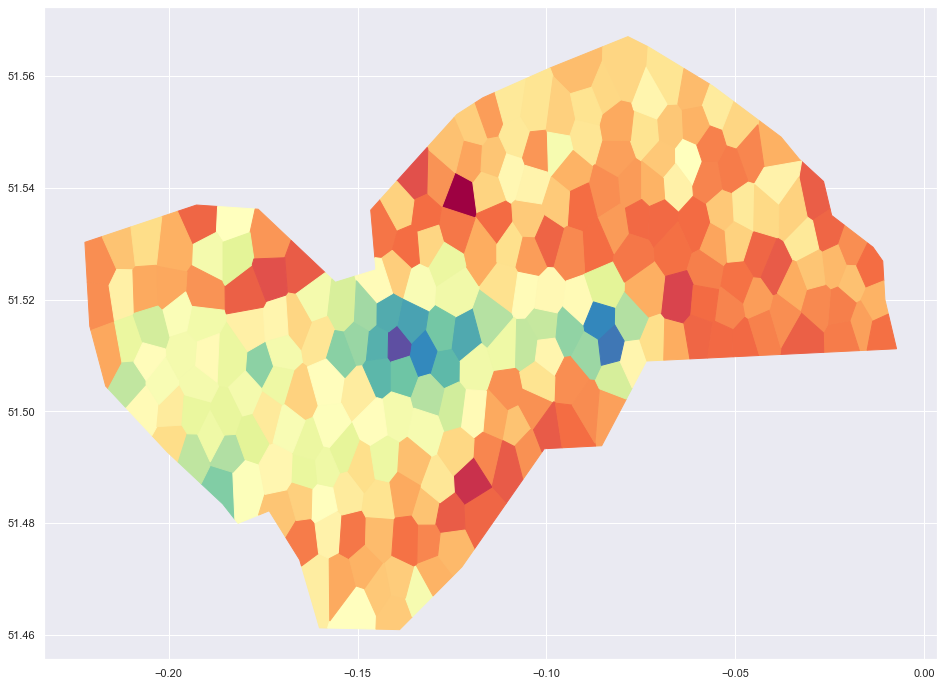

In [61]:
i = 0
p_min = torch.min(confusion_matrix[i, :])
p_max = torch.max(confusion_matrix[i, :])
pred_cell_i = 1 - (confusion_matrix[i, :] - p_min) / (p_max - p_min)
plt.figure(figsize=(16,12))
grid_partitioning.plot_prediction(pred_cell_i)

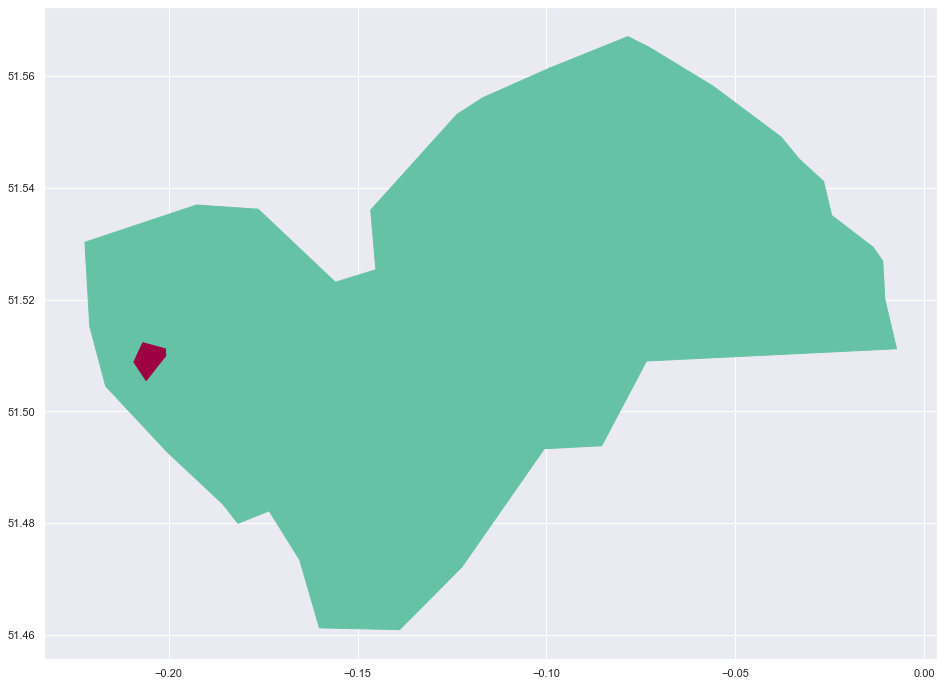

In [81]:
plt.figure(figsize=(16,12))
grid_partitioning.plot_prediction([0.8 if x != i else 0 for x in range(252)])


In [88]:
c_min = torch.min(confusion_matrix)
c_max = torch.max(confusion_matrix)


for i, cell in enumerate(grid_partitioning.cells):
    print(f'nodes.push(new Node({i}, {cell.centroid.x}, {cell.centroid.y},[', end="")
    for vertex in cell.exterior.coords:
        print('{x:' + str(round(vertex[0], 6)) + ', y:' + str(round(vertex[1], 6)) + '},', end="")
        pass
    print(f'], [', end="")
    for val in confusion_matrix[i, :]:
        print(f"{round(float((val.item()-c_min) / (c_max - c_min)), 3)}, ", end='')
        pass
    print(']))')

print('')

nodes.push(new Node(0, -0.12256201376676056, 51.53843008254098,[{x:-0.119529, y:51.541087},{x:-0.118406, y:51.535405},{x:-0.118742, y:51.534718},{x:-0.118853, y:51.534637},{x:-0.127678, y:51.536591},{x:-0.124193, y:51.542743},{x:-0.124091, y:51.542767},{x:-0.119529, y:51.541087},], [0.716, 0.479, 0.537, 0.499, 0.591, 0.418, 0.485, 0.542, 0.448, 0.287, 0.187, 0.367, 0.461, 0.411, 0.362, 0.367, 0.205, 0.227, 0.447, 0.51, 0.455, 0.599, 0.55, 0.484, 0.558, 0.505, 0.513, 0.61, 0.59, 0.599, 0.304, 0.301, 0.416, 0.424, 0.254, 0.555, 0.555, 0.501, 0.555, 0.614, 0.532, 0.412, 0.564, 0.6, 0.667, 0.529, 0.579, 0.354, 0.461, 0.49, 0.385, 0.553, 0.505, 0.63, 0.399, 0.59, 0.425, 0.544, 0.238, 0.466, 0.437, 0.393, 0.498, 0.296, 0.284, 0.477, 0.54, 0.546, 0.457, 0.53, 0.453, 0.558, 0.379, 0.52, 0.541, 0.587, 0.576, 0.574, 0.558, 0.502, 0.557, 0.432, 0.373, 0.522, 0.466, 0.533, 0.412, 0.352, 0.301, 0.402, 0.491, 0.378, 0.558, 0.458, 0.583, 0.551, 0.481, 0.612, 0.373, 0.325, 0.452, 0.477, 0.602, 0.422, 

In [87]:
confusion_matrix

tensor([[ 32.0719,   2.7862,   9.8591,  ...,  15.1715, -16.9684,  -5.9925],
        [  4.8798,  16.7480,   1.8005,  ...,  -1.5493,   7.1100,   4.1799],
        [  8.0121,   8.7788,   6.3707,  ...,   6.3504,  -8.5245,  -4.2970],
        ...,
        [ 10.4275,  -0.9397,  -1.7948,  ...,  18.6147,   0.7964,  -4.7533],
        [  7.4252,   4.3786,  -4.8228,  ...,   2.3619,  20.4094,   5.6409],
        [  5.7028,   7.8109,  -1.2382,  ...,  -2.4644,  14.2517,   9.0534]],
       device='cuda:0')